# Nanodegree Fundamentos de Machine Learning
## Modelo de Avaliação e Validação
## Projeto 1: Estimando Preços dos Imóveis de Boston

Bem-vindo ao primeiro projeto do Nanodegree de Engenheiro de Machine Learning! Neste Notebook, alguns templates de código estão sendo fornecidos para você, e você irá precisar implementar funcionalidades adicionais para completar este projeto com sucesso. Você não vai precisar modificar o código que foi incluído além do que está sendo pedido. Seções que começam com **'Implementação'** no cabeçalho indicam que o bloco de código seguinte vai exigir que você providencie funcionalidade adicional. Instruções serão fornecidas para cada seção e as especificidades da implementação são marcadas no bloco de código com o comando 'TODO'. Não esqueça de ler as instruções atentamente!

Além do código implementado, haverá questões relacionadas com o projeto e sua implementação que você deve responder. Cada seção em que há uma questão para você responder, ela será precedida por **'Questão X'** no cabeçalho. Leia cada questão cuidadosamente e dê respostas completas no seguinte box de texto que contém **'Resposta: '**. O projeto enviado será avaliado com base nas respostas para cada uma das questões e a implementação que você nos forneceu.  

>**Nota:** Células de Código e de Markdown podem ser executadas utilizando o atalho de teclado **Shift + Enter**. Além disso, as células Markdown podem ser editadas ao clicar normalmente duas vezes na célula para entrar no modo de edição.

## Antes de começar
Certifique-se que a sua versão do scikit-learn é a mesma que deve ser utilizada neste notebook. Execute a célula abaixo para verificar se sua versão é a ideal. Se você não quiser fazer *downgrade*, você precisa ficar atento as diferenças citadas ao decorrer do código.

In [1]:
import sklearn
print("A versão do scikit-learn é ", sklearn.__version__)
if sklearn.__version__ >= '0.18':
    print("Tudo certo!")
else:
    print("Você precisa fazer upgrade do scikit-learn ou ficar atento com as diferenças das versões")
    print("Pode ser feito executando:\n")
    print("pip install scikit-learn==0.18.1")

A versão do scikit-learn é  0.18.1
Tudo certo!


## Começando
Neste projeto, você irá avaliar o desempenho e o poder de estimativa de um modelo que foi treinado e testado em dados coletados dos imóveis dos subúrbios de Boston, Massachusetts. Um modelo preparado para esses dados e visto como *bem ajustado* pode ser então utilizado para certas estimativas sobre um imóvel – em particular, seu valor monetário. Esse modelo seria de grande valor para alguém como um agente mobiliário, que poderia fazer uso dessas informações diariamente.

O conjunto de dados para este projeto se origina do [repositório de Machine Learning da UCI](https://archive.ics.uci.edu/ml/datasets/Housing). Os dados de imóveis de Boston foram coletados em 1978 e cada uma das 489 entradas representa dados agregados sobre 14 atributos para imóveis de vários subúrbios de Boston. Para o propósito deste projeto, os passos de pré-processamento a seguir foram feitos para esse conjunto de dados:
- 16 observações de dados possuem um valor `'MEDV'` de 50.0. Essas observações provavelmente contêm **valores ausentes ou censurados** e foram removidas.
- 1 observação de dados tem um valor `'RM'` de 8.78. Essa observação pode ser considerada **valor atípico (outlier)** e foi removida.
- Os atributos `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` são essenciais. O resto dos **atributos irrelevantes** foram excluídos.
- O atributo `'MEDV'` foi **escalonado multiplicativamente** para considerar 35 anos de inflação de mercado.

** Execute a célula de código abaixo para carregar o conjunto dos dados dos imóveis de Boston, além de algumas bibliotecas de Python necessárias para este projeto. Você vai saber que o conjunto de dados carregou com sucesso se o seu tamanho for reportado. **

In [2]:
# Importar as bibliotecas necessárias para este projeto
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.model_selection import ShuffleSplit

# Formatação mais bonita para os notebooks
%matplotlib inline

# Executar o conjunto de dados de imóveis de Boston
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Êxito
print("O conjunto de dados de imóveis de Boston tem {} pontos com {} variáveis em cada.".format(*data.shape))

O conjunto de dados de imóveis de Boston tem 489 pontos com 4 variáveis em cada.


C:\Users\evand\Anaconda3\envs\ai_mlp3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\evand\Anaconda3\envs\ai_mlp3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
prices.describe()

count    4.890000e+02
mean     4.543429e+05
std      1.653403e+05
min      1.050000e+05
25%      3.507000e+05
50%      4.389000e+05
75%      5.187000e+05
max      1.024800e+06
Name: MEDV, dtype: float64

In [4]:
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


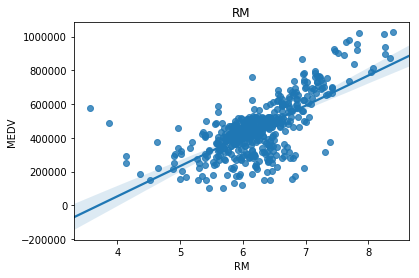

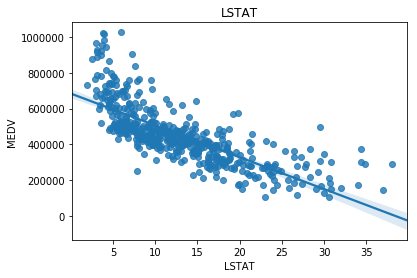

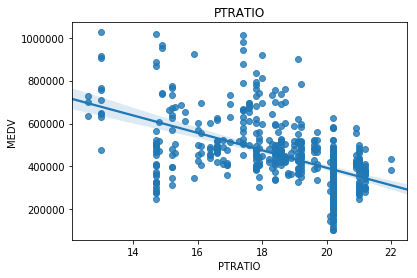

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for variable in ['RM', 'LSTAT', 'PTRATIO']:
    sns.regplot(data[variable], prices)
    plt.title(variable)
    plt.show()

## Explorando os Dados
Na primeira seção deste projeto, você fará uma rápida investigação sobre os dados de imóveis de Boston e fornecerá suas observações. Familiarizar-se com os dados durante o processo de exploração é uma prática fundamental que ajuda você a entender melhor e justificar seus resultados.

Dado que o objetivo principal deste projeto é construir um modelo de trabalho que tem a capacidade de estimar valores dos imóveis, vamos precisar separar os conjuntos de dados em **atributos** e **variável alvo**. O **atributos**, `'RM'`, `'LSTAT'` e `'PTRATIO'`, nos dão informações quantitativas sobre cada ponto de dado. A **variável alvo**, `'MEDV'`, será a variável que procuramos estimar. Eles são armazenados em `features` e ` prices`, respectivamente.

### Implementação: Calcular Estatísticas
Para a sua primeira implementação de código, você vai calcular estatísticas descritivas sobre preços dos imóveis de Boston. Dado que o `numpy` já foi importado para você, use essa biblioteca para executar os cálculos necessários. Essas estatísticas serão extremamente importantes depois para analisar várias estimativas resultantes do modelo construído.

Na célula de código abaixo, você precisará implementar o seguinte:
- Calcular o mínimo, o máximo, a média, a mediana e o desvio padrão do `'MEDV'`, que está armazenado em `prices`.
  - Armazenar cada cálculo em sua respectiva variável.

In [6]:
# TODO: Preço mínimo dos dados
minimum_price = np.min(prices)

# TODO: Preço máximo dos dados
maximum_price = np.max(prices)

# TODO: Preço médio dos dados
mean_price = np.mean(prices)

# TODO: Preço mediano dos dados
median_price = np.median(prices)

# TODO: Desvio padrão do preço dos dados
std_price = np.std(prices)

# Mostrar as estatísticas calculadas
print("Estatísticas para os dados dos imóveis de Boston:\n")
print("Preço mínimo: ${:,.2f}".format(minimum_price))
print("Preço máximo: ${:,.2f}".format(maximum_price))
print("Preço médio: ${:,.2f}".format(mean_price))
print("Preço mediano: ${:,.2f}".format(median_price))
print("Desvio padrão dos preços: ${:,.2f}".format(std_price))

Estatísticas para os dados dos imóveis de Boston:

Preço mínimo: $105,000.00
Preço máximo: $1,024,800.00
Preço médio: $454,342.94
Preço mediano: $438,900.00
Desvio padrão dos preços: $165,171.13


### Questão 1 - Observação de Atributos
Para lembrar, estamos utilizando três atributos do conjunto de dados dos imóveis de Boston: `'RM'`, `'LSTAT'` e `'PTRATIO'`. Para cada observação de dados (vizinhança):
- `'RM'` é o número médio de cômodos entre os imóveis na vizinhança.
- `'LSTAT'` é a porcentagem de proprietários na vizinhança considerados de "classe baixa" (proletariado).
- `'PTRATIO'` é a razão de estudantes para professores nas escolas de ensino fundamental e médio na vizinhança.

**Usando a sua intuição, para cada um dos atributos acima, você acha que um aumento no seu valor poderia levar a um _aumento_ no valor do `'MEDV'` ou uma _diminuição_ do valor do `'MEDV'`? Justifique sua opinião para cada uma das opções.**  

**Dica:** Você pode tentar responder pensando em perguntas como:
* Você espera que um imóvel que tem um valor `'RM'` de 6 custe mais ou menos que um imóvel com valor `'RM'` de 7?
* Você espera que um imóvel em um bairro que tem um valor `'LSTAT'` de 15 custe mais ou menos que em um bairro com valor `'LSTAD'` de 20?
* Você espera que um imóvel em um bairro que tem um valor `'PTRATIO'` de 10 custe mais ou menos que em um bairro com `'PTRATIO'` de 15?

**Resposta:**

*Imagino que eles estejam meio que ligados.
 O que torna difícil afirmar se vai aumentar ou diminuir avaliando o aumento de apenas um parâmetro.
 Exemplo:
 Aumentar RM, o lógico seria pensar que vai aumentar o preço. Mas, para isso LSTAT e PTRAIO deveriam se manter.
 Pois um imóvel com LSTAT maior, tende a fazer o preço do imóvel ser mais baixo. Assim como um PTRATIO maior, tende a fazer o preço cair, já que serão menos professores por aluno. O que reflete em menos atenção para cada aluno e pode fazer a qualidade do ensino dominuir.*


----

## Desenvolvendo um Modelo
Na segunda seção deste projeto, você vai desenvolver ferramentas e técnicas necessárias para um modelo que faz estimativas. Ser capaz de fazer avaliações precisas do desempenho de cada modelo através do uso dessas ferramentas e técnicas ajuda a reforçar a confiança que você tem em suas estimativas.

### Implementação: Definir uma Métrica de Desempenho
É difícil medir a qualidade de um modelo dado sem quantificar seu desempenho durante o treinamento e teste. Isso é geralmente feito utilizando algum tipo de métrica de desempenho, através do cálculo de algum tipo de erro, qualidade de ajuste, ou qualquer outra medida útil. Para este projeto, você irá calcular o [*coeficiente de determinação*](https://pt.wikipedia.org/wiki/R%C2%B2), R<sup>2</sup>, para quantificar o desempenho do seu modelo. O coeficiente de determinação é uma estatística útil no campo de análise de regressão uma vez que descreve o quão "bom" é a capacidade do modelo em fazer estimativas. 

Os valores para R<sup>2</sup> têm um alcance de 0 a 1, que captura a porcentagem da correlação ao quadrado entre a estimativa e o valor atual da **variável alvo**. Um modelo R<sup>2</sup> de valor 0 sempre falha ao estimar a variável alvo, enquanto que um modelo R<sup>2</sup> de valor 1, estima perfeitamente a variável alvo. Qualquer valor entre 0 e 1 indica qual a porcentagem da variável alvo (ao utilizar o modelo) que pode ser explicada pelos **atributos**. *Um modelo pode dar também um R<sup>2</sup> negativo, que indica que o modelo não é melhor do que aquele que estima ingenuamente a média da variável alvo.*

Para a função ‘performance_metric’ na célula de código abaixo, você irá precisar implementar o seguinte:
- Utilizar o `r2_score` do `sklearn.metrics` para executar um cálculo de desempenho entre `y_true` e `y_predict`.
- Atribuir a pontuação do desempenho para a variável `score`.

In [7]:
# TODO: Importar 'r2_score'

def performance_metric(y_true, y_predict):
    """ Calcular e retornar a pontuação de desempenho entre 
        valores reais e estimados baseado na métrica escolhida. """
    
    from sklearn.metrics import r2_score
    
    # TODO: Calcular a pontuação de desempenho entre 'y_true' e 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Devolver a pontuação
    return score

### Questão 2 - Qualidade do Ajuste
Admita que um conjunto de dados que contém cinco observações de dados e um modelo fez a seguinte estimativa para a variável alvo:

| Valores Reais | Estimativa |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

** Executar a célula de código abaixo para usar a função `performance_metric’ e calcular o coeficiente de determinação desse modelo. **

In [8]:
# Calcular o desempenho deste modelo
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("O coeficiente de determinação, R^2, do modelo é {:.3f}.".format(score))

O coeficiente de determinação, R^2, do modelo é 0.923.


* Você consideraria que esse modelo foi capaz de capturar a variação da variável alvo com sucesso? Por que ou por que não?

** Dica: **
* R2 score com valor 0 significa que a variável dependente não pode ser estimada pela variável independente.
* R2 score com valor 1 significa que a variável dependente pode ser estimada pela variável independente.
* R2 score com valor entre 0 e 1 significa quanto a variável dependente pode ser estimada pela variável independente.
* R2 score com valor 0.40 significa que 40 porcento da variância em Y é estimável por X.

**Resposta:** 

*Como o coeficiente(R^2) ficou muito próximo de 1, valores previstos muito próximos do valor estimado. Considero que esse modelo foi capaz de capturar a variação da variável alvo com sucesso.*

### Implementação: Misturar e Separar os Dados
Sua próxima implementação exige que você pegue o conjunto de dados de imóveis de Boston e divida os dados em subconjuntos de treinamento e de teste. Geralmente os dados são também misturados em uma ordem aleatória ao criar os subconjuntos de treinamento e de teste para remover qualquer viés (ou erro sistemático) na ordenação do conjunto de dados.

Para a célula de código abaixo, você vai precisar implementar o seguinte:
- Utilize `train_test_split` do `sklearn.model_selection` para misturar e dividir os dados de `features` e `prices` em conjuntos de treinamento e teste. Leia mais [aqui](http://scikit-learn.org/0.19/modules/generated/sklearn.model_selection.train_test_split.html).
  - Divida os dados em 80% treinamento e 20% teste.
  - Mude o `random_state` do `train_test_split` para um valor de sua escolha. Isso garante resultados consistentes.
- Atribuir a divisão de treinamento e teste para X_train`, `X_test`, `y_train` e `y_test`.

In [9]:
# TODO: Importar 'train_test_split'
from sklearn.model_selection import train_test_split

# TODO: Misturar e separar os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.20)

# Êxito
print("Separação entre treino e teste feita com êxito.")

Separação entre treino e teste feita com êxito.


### Questão 3 - Treinamento e Teste
* Qual o benefício de separar o conjunto de dados em alguma relação de subconjuntos de treinamento e de teste para um algoritmo de aprendizagem?

**Dica:** O que pode dar errado se não houver uma maneira de testar seu modelo?

**Resposta: **

*O maior benefício em separar um conjunto dados em treinamento e teste é a validação, garantindo que o subconjunto de teste não estará contido no de treino, e assim, teremos certeza que o nosso modelo preveja um valor novo. Se todo o conjunto de dados for usado para treinamento, ocorrerá um overfitting e o conjunto de dados não seria generalizado.* *Da mesma forma, se usarmos todo o conjunto de dados para testes, o modelo não teria aprendido nada e seria generalizado.*

*Com isso, os valores seriam previstos com pouco precisão.*
*Uma proporção adequada de treinamento e teste otimiza o cenário, utilizando dados suficientes treinar o algoritmo com uma boa configuração, a fim de medir/validar dados ainda não vistos. Aumentando a precisão do modelo e evitando erros devido ao viés de alta e a variância.*



----

## Analisando o Modelo de Desempenho
Na terceira parte deste projeto, você verá o desempenho em aprendizagem e teste de vários modelos em diversos subconjuntos de dados de treinamento. Além disso, você irá investigar um algoritmo em particular com um parâmetro `'max_depth'` (profundidade máxima) crescente, em todo o conjunto de treinamento, para observar como a complexidade do modelo afeta o desempenho. Plotar o desempenho do seu modelo baseado em critérios diversos pode ser benéfico no processo de análise, por exemplo: para visualizar algum comportamento que pode não ter sido aparente nos resultados sozinhos.

### Curvas de Aprendizagem
A célula de código seguinte produz quatro gráficos para um modelo de árvore de decisão com diferentes níveis de profundidade máxima. Cada gráfico visualiza a curva de aprendizagem do modelo para ambos treinamento e teste, assim que o tamanho do conjunto treinamento aumenta. Note que a região sombreada da curva de aprendizagem denota a incerteza daquela curva (medida como o desvio padrão). O modelo é pontuado em ambos os conjuntos treinamento e teste utilizando R<sup>2</sup>, o coeficiente de determinação.  

**Execute a célula de código abaixo e utilizar esses gráficos para responder as questões a seguir.**

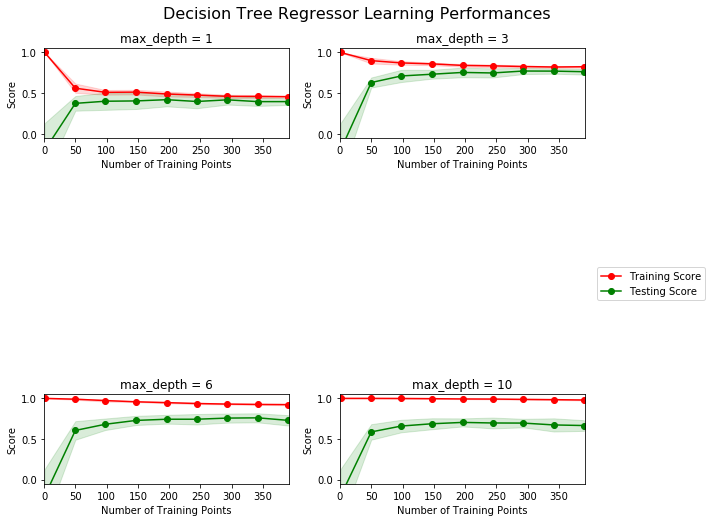

In [13]:
# Criar curvas de aprendizagem para tamanhos de conjunto de treinamento variável e profundidades máximas
vs.ModelLearning(features, prices)

### Questão 4 - Compreendendo os Dados
* Escolha qualquer um dos gráficos acima e mencione a profundidade máxima escolhida.
* O que acontece com a pontuação da curva de treinamento se mais pontos de treinamento são adicionados? E o que acontece com a curva de teste?
* Ter mais pontos de treinamento beneficia o modelo?

**Dica:** As curvas de aprendizagem convergem para uma pontuação em particular? Geralmente, quanto mais dados você tem, melhor. Mas, se sua curva de treinamento e teste estão convergindo com um desempenho abaixo do benchmark, o que seria necessário? Pense sobre os prós e contras de adicionar mais pontos de treinamento baseado na convergência das curvas de treinamento e teste.

**Resposta:**

*O gráfico com com max_depth = 3, parece ser o que mais se aproxima do score 1.* 

*Conforme mais pontos de treinamento são adicionados, sua pontuação diminui e parece estabilizar, enquanto sua variação / incerteza da curva também diminui. A pontuação da curva de teste também aumenta à medida que mais pontos de dados são fornecidos, já que tende a nivelar e correr paralelamente à curva de treinamento.*

Outro ponto entre 150 e 200, já temos uma boa melhora do score. Apartir de 200, estariamos apenas degradando a performance do modelo e não haveria ganho em adicionar mais pontos.*


### Curvas de Complexidade
A célula de código a seguir produz um gráfico para um modelo de árvore de decisão que foi treinada e validada nos dados de treinamento utilizando profundidades máximas diferentes. O gráfico produz duas curvas de complexidade – uma para o treinamento e uma para a validação. Como a **curva de aprendizagem**, a área sombreada de ambas as curvas de complexidade denota uma incerteza nessas curvas, e o modelo pontuou em ambos os conjuntos de treinamento e validação utilizando a função `performance_metric`.  

** Execute a célula de código abaixo e utilize o gráfico para responder as duas questões a seguir. **

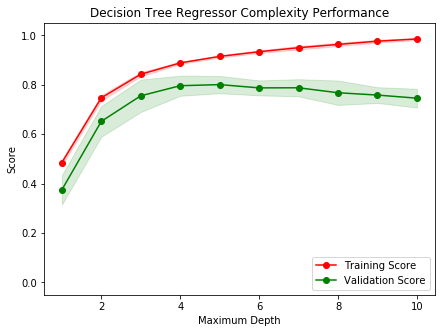

In [19]:
vs.ModelComplexity(X_train, y_train)

### Questão 5 - Equilíbrio entre viés e variância
* Quando o modelo é treinado com o profundidade máxima 1, será que o modelo sofre mais de viés (erro sistemático) ou variância (erro aleatório)?
* E o que acontece quando o modelo é treinado com profundidade máxima 10? Quais pistas visuais existem no gráfico para justificar suas conclusões?

**Dica:** Como você sabe que um modelo está experimentando viés alto ou variância alta? Viés alto é um sinal de *underfitting* (o modelo não é complexo o suficiente para aprender os dados) e alta variância é um sinal de *overfitting* (o modelo está "decorando" os dados e não consegue generalizar bem o problema). Pense em modelos (com profundidade de 1 e 10, por exemplo) e qual deles está alinhado com qual parte do equilíbrio.

**Resposta:**

*Com profundidade 1, temos o que chamamos de underfitting.Pois, o modelo acaba ficando generalizado e tendo mais viés.*

*Com profundidade 10, temos o efeito contrário, que chamamos de overfitting. Com score alto nos dados de treinamento, 
mas score baixa nos dados de teste.*

*Quando um número mínimo de recursos é usado(profundidade máxima 1), é comum um modelo sofrer de alto viés. Isto dá um valor baixo de R^2(perto de 0) e falta de ajuste. Com isso, ele acaba ficando simples e generalizável, com um baixo score nos dados de treino e principalmente nos dados de testes e caracteriza um caso de underfitting.*

*O contrário acontece ao treinar o modelo com profundidade máxima 10. Ele tem um alto valor de R^2(aproximando-se de 1),  e acaba sofrendo mais com a variância, com um alto score para os dados de treino e baixo score para os dados de testes. Nesse caso o modelo se ajusta muito com os dados de treino e não consegue generalizar nos dados de testes e caracteriza um caso de  overfitting.*


### Questão 6 - Modelo Ótimo de Melhor Suposição
* Qual profundidade máxima (`'max_depth'`) você acredita que resulta em um modelo que melhor generaliza um dado desconhecido?
* Que intuição te levou a essa resposta?

**Dica: ** Olhe no gráfico acima e veja o desempenho de validação para várias profundidades atribuidas ao modelo. Ele melhora conforme a profundidade fica maior? Em qual ponto nós temos nosso melhor desempenho de validação sem supercomplicar nosso modelo? E lembre-se, de acordo com a [Navalha de Occam](https://pt.wikipedia.org/wiki/Navalha_de_Occam), sempre devemos optar pelo mais simples ao complexo se ele conseguir definir bem o problema.

**Resposta:**

Olhando para o modelo, inicialmente fiquei entre o 3 e 4. 
Com o 3, teremos um desempenho aprimorado do modelo, que parece ser a melhor escolha.
Pois resultaria em um modelo mais generalizado.

No 4, tempos um melhor score, com um custo um pouco maior. 
Porém, a partir deste ponto não temos um ganho para Validation, apesar da curva de Training se proximar de 1, o nível de incerteza começa aumentar entre Validation e Training.

-----

## Avaliando o Desempenho do Modelo
Nesta parte final do projeto, você irá construir um modelo e fazer uma estimativa de acordo com o conjunto de atributos do cliente utilizando um modelo otimizado a partir de `fit_model`.

### Questão 7 - Busca em Matriz
* O que é a técnica de busca em matriz (*grid search*)?
* Como ela pode ser aplicada para otimizar um algoritmo de aprendizagem?

** Dica: ** Quando explicar a técnica de busca em matriz, tenha certeza que você explicou o motivo dela ser usada, o que a 'matriz' significa nesse caso e qual o objetivo da técnica. Para ter uma resposta mais sólida, você pode também dar exemplo de um parâmetro em um modelo que pode ser otimizado usando essa técnica.

**Resposta:**

*A técnica de busca em matriz, atravéz da combinação de hyperparâmetros, automatiza o processo de ajuste de parâmetros de um modelo a fim de obter o melhor desempenho.*
*Permite fazer vários testes rápidos, que ajudam a otimizar o algoritmo. Uma vez que é possível testar todas as combinações de hyperparâmetros que estão na matriz.*

Como exemplo, vamos verificar qual o melhor valor de C para o treinar nossa regressão logística(LogisticRegression).
- Criamos uma lista que receberá o valores de 1 a 10.
- Chamamos o GridSearchCV passando para ele o nosso classificador e os parâmetros(lista).
- Em seguida informamos que queremos testar cada modelo usando uma validação cruzada com 10 folds (cv=10).


- *Basicamente, a função do parâmetro C é controlar a complexidade do modelo.*
- *Um valor mais baixo siginifica que queremos modelos mais complexos e um valor mais alto o contrário.*


- Dica do revisor e Material de apoio: http://minerandodados.com.br/index.php/2018/01/17/gridsearch-algoritmo-machine-learning/

### Questão 8 - Validação Cruzada
* O que é a técnica de treinamento de validação-cruzada k-fold?
* Quais benefícios essa técnica proporciona para busca em matriz ao otimizar um modelo?

**Dica:** Lembre-se de expllicar o que significa o 'k' da validação-cruzada k-fold, como a base de dados é dividida e quantas vezes ela é executada.

Assim como há um raciocínio por trás de utilizar um conjunto de teste, o que poderia dar errado ao utilizar busca em matriz sem um conjunto de validação cruzada? Você pode utilizar a [documentação](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) para basear sua resposta.

**Resposta:**

*A técnica de validação cruzada(k-fold) nos permite dividir o conjunto de treino e teste menores pedaços.
Com isso, podemos utilizar dados que seriam descartadosno conjunto de testes e ao mesmo tempo manter a regra de não usar dados de testes para treinamento.*

*Ao treinar o modelo em k vezes, a média das experiências de teste k é usada como o resultado geral do modelo.*

- Dica do revisor e Material de apoio: https://www.youtube.com/watch?v=RczbeFs_WbQ 

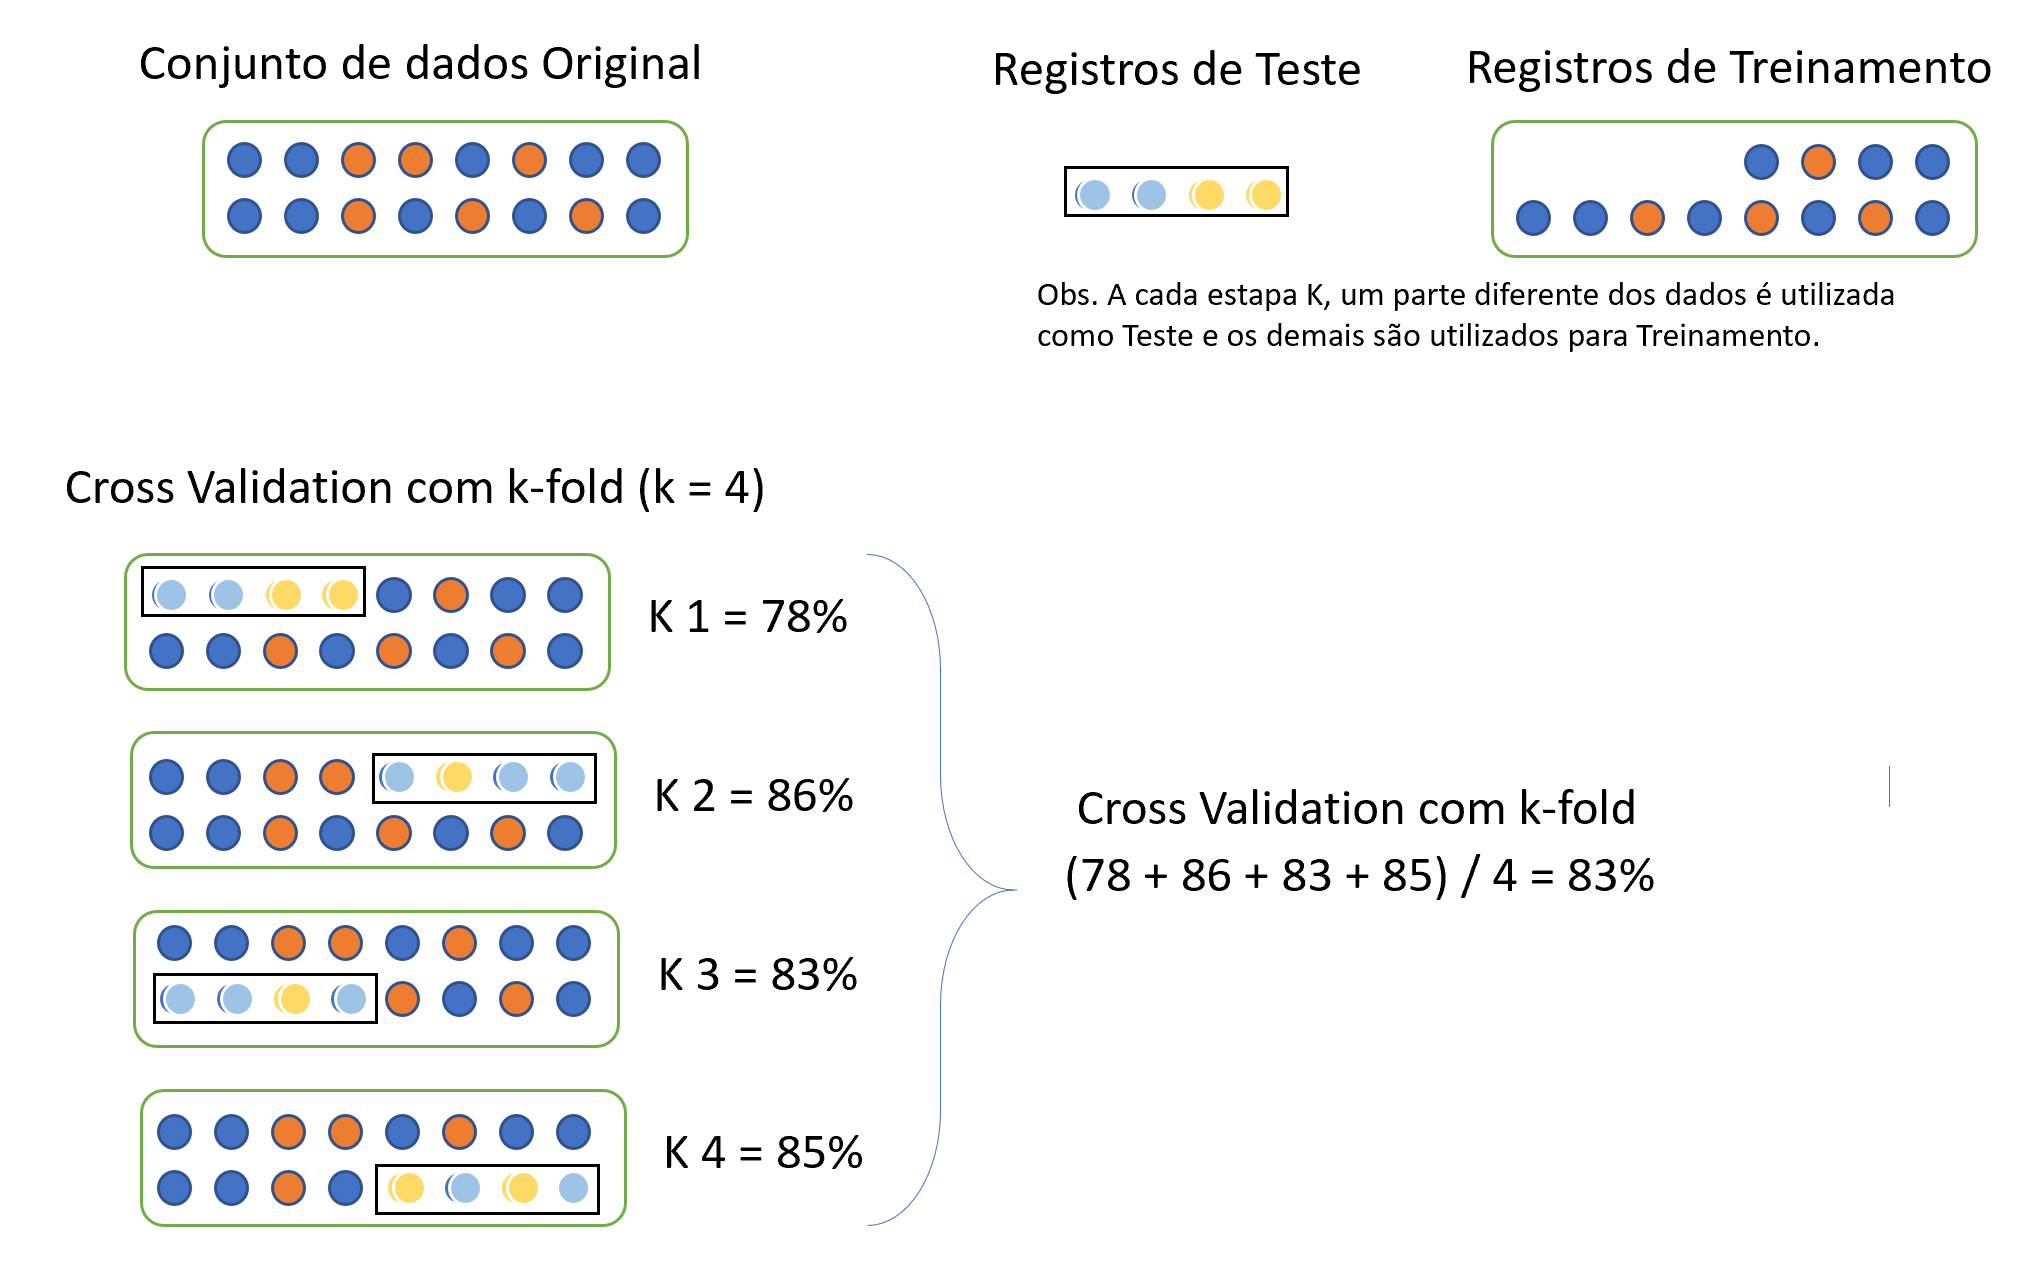

In [16]:
#Imagem criada para ajudar a ilustar a explicação acima.
from IPython.display import Image
Image(filename='img/k-fold.png', width=600, height=600)

### Implementação: Ajustar um Modelo
Na sua última implementação, você vai precisar unir tudo o que foi aprendido e treinar um modelo utilizando o **algoritmo de árvore de decisão**. Para garantir que você está produzindo um modelo otimizado, você treinará o modelo utilizando busca em matriz para otimizar o parâmetro de profundidade máxima (`'max_depth'`) para uma árvore de decisão. Esse parâmetro pode ser entendido como o número de perguntas que o algoritmo de árvore de decisão pode fazer sobre os dados antes de fazer uma estimativa. Árvores de decisão são parte de uma classe de algoritmos chamados *algoritmos de aprendizagem supervisionada*.

Além disso, você verá que a implementação está usando o `ShuffleSplit()` como alternativa para a validação cruzada (veja a variável `cv_sets`). Ela não é a técnica que você descreveu na **Questão 8**, mas ela é tão útil quanto. O `ShuffleSplit()` abaixo irá criar 10 (`n_splits`) conjuntos misturados e 20% (`test_size`) dos dados serão utilizados para validação. Enquanto estiver trabalhando na sua implementação, pense nas diferenças e semelhanças com a validação k-fold.

* [ShuffleSplit](http://scikit-learn.org/0.18/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) - `ShuffleSplit(n_splits=10, test_size=’default’, train_size=None, random_state=None)`

Para a função `fit_model` na célula de código abaixo, você vai precisar implementar o seguinte:
- Utilize o [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) do `sklearn.tree` para gerar um objeto regressor de árvore de decisão.
  - Atribua esse objeto à variável `'regressor'`.
- Gere um dicionário para `'max_depth'` com os valores de 1 a 10 e atribua isso para a variável `'params'`.
- Utilize o [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) do `sklearn.metrics` para gerar um objeto de função de pontuação.
  - Passe a função `performance_metric` como um parâmetro para esse objeto.
  - Atribua a função de pontuação à variável `'scoring_fnc'`.
- Utilize o [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) do `sklearn.grid_search` para gerar um objeto de busca por matriz.
  - Passe as variáveis `'regressor'`, `'params'`, `'scoring_fnc'` and `'cv_sets'` como parâmetros para o objeto. 
  - Atribua o objeto `GridSearchCV` para a variável `'grid'`.

In [31]:
# TODO: Importar 'make_scorer', 'DecisionTreeRegressor' e 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Desempenhar busca em matriz sobre o parâmetro the 'max_depth' para uma 
        árvore de decisão de regressão treinada nos dados de entrada [X, y]. """
    
    # Gerar conjuntos de validação-cruzada para o treinamento de dados
    cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state = 0)

    
    # TODO: Gerar uma árvore de decisão de regressão de objeto
    regressor = DecisionTreeRegressor(random_state=0)

    # TODO: Gerar um dicionário para o parâmetro 'max_depth' com um alcance de 1 a 10
    params = {'max_depth':range(1,11)}

    # TODO: Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    

    # TODO: Gerar o objeto de busca em matriz
    grid = GridSearchCV(regressor, params)
    #grid = GridSearchCV(regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
    grid = grid.fit(X, y)

    # Devolver o modelo ótimo depois de realizar o ajuste dos dados
    return grid.best_estimator_

### Fazendo Estimativas
Uma vez que o modelo foi treinado em conjunto de dados atribuído, ele agora pode ser utilizado para fazer estimativas em novos conjuntos de entrada de dados. No caso do *regressor da árvore de decisão*, o modelo aprendeu *quais são as melhores perguntas sobre a entrada de dados*, e pode responder com uma estimativa para a **variável alvo**. Você pode utilizar essas estimativas para conseguir informações sobre os dados dos quais o valor da variável alvo é desconhecida – por exemplo, os dados dos quais o modelo não foi treinado.

### Questão 9 - Modelo Ótimo
* Qual profundidade máxima do modelo ótimo? Como esse resultado se compara com a sua suposição na **Questão 6**?  

** Executar a célula de código abaixo para ajustar o regressor da árvore de decisão com os dados de treinamento e gerar um modelo ótimo. **

In [32]:
# Ajustar os dados de treinamento para o modelo utilizando busca em matriz
reg = fit_model(X_train, y_train)

# Produzir valores para 'max_depth'
print("O parâmetro 'max_depth' é {} para o modelo ótimo.".format(reg.get_params()['max_depth']))

O parâmetro 'max_depth' é 5 para o modelo ótimo.


**Dica: ** A resposta vem da saída do código acima.

**Resposta:**

*O modelo foi identificado com profundidade máxima de 5. Este é diferente do meu palpite na questão 6 que ficou entre 3 ou 4.*



### Questão 10 - Estimando Preços de Venda
Imagine que você era um corretor imobiliário na região de Boston ansioso para utilizar esse modelo que ajuda os imóveis que seus clientes desejam vender. Você coletou as seguintes informações de três dos seus clientes:

| Atributos | Cliente 1 | Cliente 2 | Cliente 3 |
| :---: | :---: | :---: | :---: |
| Número total de cômodos em um imóvel | 5 cômodos | 4 cômodos | 8 cômodos |
| Nível de pobreza da vizinhança (em %) | 17% | 32% | 3% |
| Razão estudante:professor das escolas próximas | 15-to-1 | 22-to-1 | 12-to-1 |
* Qual valor você sugeriria para cada um dos seus clientes para a venda de suas casas?
* Esses preços parecem razoáveis dados os valores para cada atributo?*  


** Execute a célula de códigos abaixo para que seu modelo otimizado faça estimativas para o imóvel de cada um dos clientes.**

In [28]:
# Gerar uma matriz para os dados do cliente
client_data = [[5, 17, 15], # Cliente 1
               [4, 32, 22], # Cliente 2
               [8, 3, 12]]  # Cliente 3

# Mostrar estimativas
for i, price in enumerate(reg.predict(client_data)):
    print("Preço estimado para a casa do cliente {}: ${:,.2f}".format(i+1, price))

Preço estimado para a casa do cliente 1: $426,510.00
Preço estimado para a casa do cliente 2: $289,800.00
Preço estimado para a casa do cliente 3: $888,825.00


**Resposta:**

*Os valore encontrados parecem estar condizentes. Vou utilizar o cliente 1 (preço mediano) para explicar as analises*
- *O cliente 1 tem uma casa mediana, pois tem menos quartos que o Cliente 3 e mais quartos que o cliente 2.* 
- *O cliente 1 está em uma vizinhaça com o nível média no indice de probreza. Que á maior que o do cliente 3 e menor do que o cliente 2.* 
- *O cliente 1 tem o indicador médio de alunos por professor, já o cliente 3 possui o menor indicador( o que favorece um preço maior) o cliente 2 possui o maior indicador(o que favorece um preço menor)*


| Atributos | Cliente 1 | Cliente 2 | Cliente 3 |
| :---: | :---: | :---: | :---: |
| Número total de cômodos em um imóvel | 5 cômodos | 4 cômodos | 8 cômodos |
| Nível de pobreza da vizinhança (em %) | 17% | 32% | 3% |
| Razão estudante:professor das escolas próximas | 15-to-1 | 22-to-1 | 12-to-1 |
|Valor Recomendado (em US$)	|426,510.00	|289,800.00	|888,825.00 |


**Complentando:**
- Casa do Cliente 1 tem Preço 426,510.00 muito próximo do preço mediano 438,900.00
- Caso do Cliente 2 tem preço 289,800.00 que é abaixo do preço mediano 438,900.00
- Casa do Cliente 3 tem preço 888,825.00 que é acima do preço mediano 438,900.00 e muito próximo do preço máximo 1,024,800.00


### Sensibilidade
Um modelo ótimo não é necessariamente um modelo robusto. Às vezes, um modelo é muito complexo ou muito simples para generalizar os novos dados. Às vezes, o modelo pode utilizar um algoritmo de aprendizagem que não é apropriado para a estrutura de dados especificado. Outras vezes, os próprios dados podem ter informação excessiva ou exemplos insuficientes para permitir que o modelo apreenda a variável alvo – ou seja, o modelo não pode ser ajustado.

** Execute a célula de código abaixo para rodar a função `fit_model` dez vezes com diferentes conjuntos de treinamento e teste para ver como as estimativas para um cliente específico mudam se os dados foram treinados.**

In [29]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $411,000.00
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $428,316.00
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $28,652.84


### Questão 11 - Aplicabilidade
* Em poucas linhas, argumente se o modelo construído deve ou não ser utilizado de acordo com as configurações do mundo real.

**Dica:** Olhe os valores calculados acima. Algumas questões para responder:
* Quão relevante dados coletados em 1978 podem ser nos dias de hoje? A inflação é importante?
* Os atributos presentes são suficientes para descrever um imóvel?
* Esse modelo é robusto o suficiente para fazer estimativas consistentes?
* Dados coletados em uma cidade urbana como Boston podem ser aplicados para uma cidade rural?
* É justo julgar o preço de um único imóvel baseado nas características de todo o bairro?

**Resposta:**

- *Relevância: Os dados foram coletados em 1978, e reflete a realidade de aproximadamente 40 anos(já que estamos em 2018).*
- *Robustes: O modelo não parece robusto o sufinete, pois encontramos vários valores para o mesmo cliente em uma sequencia de execuções.*
- *Atributos: Estes são apenas atribuits básicos,  apesar de estarem relacionados, são insuficientes para descrever um imóvel.*
  *Outros, atributos poderiam deixar o modelo de dados mais relevantes para descrever o imóvel.*
  *Lalguns deles seriam: Tamanho do terreno,tamanho da area contruida( pois podem ter vários quartos, porém serem pequenos),*     *tipos de transporte publicos, etc.*
- *Aplicabilidade: Estes dados não podem ser utilizados para cidade rural.* 
  *Assim, como descrito acima que faltam atributos, as informações para os mesmos atributos em uma cidade rural seriam*    *diferentes.*
- *Preço: Dificil dizer se é justo, sem conhecermos todas as variantes envolvidas.* 
  *Porém, baseados em modelos preditivos coerentes, podemos chegar a um valor muito próximo do real.*


> **Nota**: Uma vez que você tenha completado todos os códigos e respondido todas as questões acima, você pode finalizar seu trabalho exportando o iPython Notebook como um documento HTML.
Você pode fazer isso usando o menu acima e navegando até
* **File -> Download as -> HTML (.html)**
* **Arquivo -> Download como -> HTML (.html)**

> Inclua o documento gerado junto com esse notebook na sua submissão.